In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
from os.path import dirname, join as pjoin
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pytorch_lightning as pl
from sklearn.metrics import r2_score

from func2graph import data, baselines, tools

In [18]:
eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
GT_strength_connectivity = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')
abs_max = np.max(np.abs(GT_strength_connectivity))
vmin_KK = -abs_max
vmax_KK = abs_max

no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']
corr =  -0.41559179936605906 , spearman =  -0.3316146644668484
0.41559179936605906


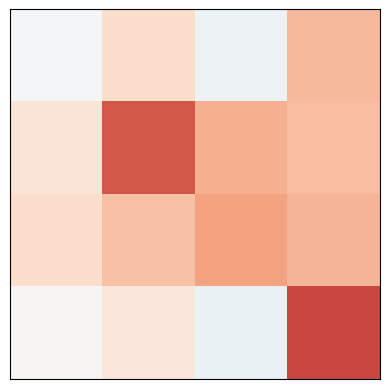

In [19]:
# Just look at one session

input_mouse = ['SB025']
input_sessions = [['2019-10-23']]

k = 1  #############################

batch_size = 32
normalization = 'destd'   ######################### !!!!!!!!  "all" for tanh, "destd" for exp
train_dataloader_list, val_dataloader_list, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, sessions_2_original_cell_type, neuron_id_2_cell_type_id = data.generate_mouse_all_sessions_data_for_GLM(
    input_mouse=input_mouse,
    input_sessions=input_sessions,
    k=k, 
    batch_size=batch_size, 
    normalization=normalization
)

# Load the trained model
checkpoint_path = "../../output/Baselines/GLM_M_exp_42.ckpt"   #############################
trained_model = baselines.GLM_M.load_from_checkpoint(checkpoint_path=checkpoint_path)
trained_model.eval()


NN_list = []   # should contrain k NN matrices
KK_list = []   # should contrain k kk matrices
for j in range(k):
    NN = trained_model.W_list[j].weight.data.cpu().detach().numpy()
    NN_list.append(NN)

    KK_strength = tools.multisession_NN_to_KK_1(
        [NN], 
        None,
        cell_type_order,
        [all_sessions_new_cell_type_id[0]],
    )
    eval_KK_strength = tools.experiment_KK_to_eval_KK(KK_strength, cell_type_order, eval_cell_type_order)

    KK_list.append(eval_KK_strength)
    corr = stats.pearsonr(GT_strength_connectivity.flatten(), eval_KK_strength.flatten())[0]
    spearman = stats.spearmanr(GT_strength_connectivity.flatten(), eval_KK_strength.flatten())[0]

    print("corr = ", corr, ", spearman = ", spearman)

    transformed_eval_KK_strength = tools.linear_transform(eval_KK_strength, GT_strength_connectivity)

    print(stats.pearsonr(GT_strength_connectivity.flatten(), transformed_eval_KK_strength.flatten())[0])

    plt.imshow(-1 * transformed_eval_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
    plt.xticks([])
    plt.yticks([])
    plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 603.01it/s]

PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  380            	|  1.403          	


torch.Size([32, 1054])
(788, 1054)


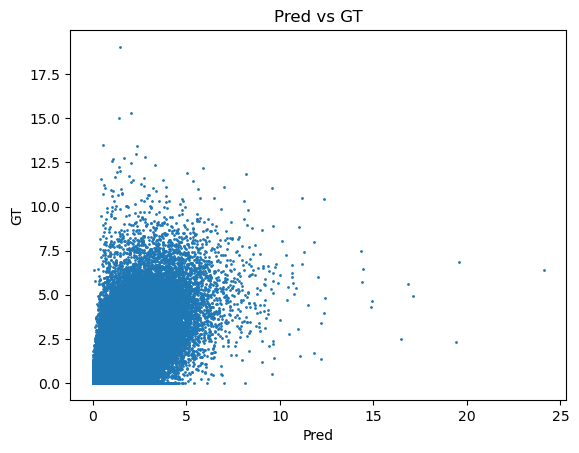

MSE =  0.47421145
corr 0.7002205654682627
flattened R^2 0.48054594166483733
unflattened R^2 -0.1130883486110187


In [20]:
trainer = pl.Trainer(
    devices=[0],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)
val_results = trainer.predict(trained_model, dataloaders=[val_dataloader_list[0]])
print(val_results[0].shape)

val_results = torch.cat(val_results, dim=0).cpu().detach().numpy()
print(val_results.shape)

pred = val_results[:, 0:int(val_results.shape[1]/2)]
gt = val_results[:, int(val_results.shape[1]/2):]

plt.scatter(pred.flatten(), gt.flatten(), s=1)
plt.xlabel("Pred")
plt.ylabel("GT")
plt.title("Pred vs GT")
plt.show()

mse = np.mean((pred - gt)**2)
print("MSE = ", mse)
print('corr', stats.pearsonr(gt.flatten(), pred.flatten())[0])
print('flattened R^2', r2_score(gt.flatten(), pred.flatten()))
print('unflattened R^2', r2_score(gt, pred, multioutput='variance_weighted'))

no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']
torch.Size([4198, 460])
torch.Size([4198, 460])


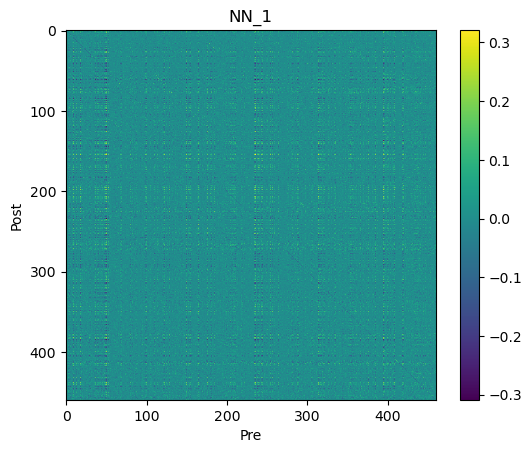

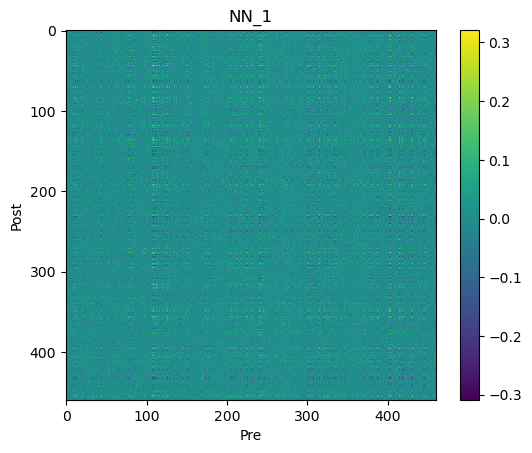

tensor([-4.6947e-04, -1.7378e+00,  4.9576e-01, -1.2950e+00, -7.6808e-02,
         1.1869e-01,  4.2022e+00,  3.9106e-01, -2.4898e-01,  4.6709e-01,
         2.9772e-01, -4.8747e-02,  6.9023e-02,  7.4813e-02,  3.7434e-01,
        -1.8709e-01,  1.9133e+00, -7.7363e-01, -4.4315e-02, -1.8021e-01,
        -2.0859e-01,  7.5301e-01,  1.1718e-01, -8.5036e-01,  1.0446e+00,
         2.2980e+00, -1.2887e+00, -1.3613e+00, -6.0694e-02,  5.6362e-01,
         6.2113e-01,  4.8693e-01,  4.1252e+00,  3.6072e+00, -2.1175e-01,
         1.3945e-01, -6.2870e-01, -3.3447e-01, -1.1145e-01, -1.2359e+00,
         2.9323e-01,  2.2339e+00,  1.4487e+00, -8.1870e-01,  7.0311e-01,
         8.5113e-01,  1.2991e-01,  3.9356e-02, -2.6485e-01,  1.1984e+00,
         1.6643e-01,  2.2380e+00, -4.8399e-01, -1.4865e-01,  5.0132e-01,
        -7.8344e-01,  2.9039e+00,  2.3428e+00, -4.4872e-01, -2.0215e-01,
        -7.6134e-01,  2.8766e+00,  4.9004e-01,  2.7585e+00, -6.1098e-01,
         1.3256e+00,  4.5593e+00, -2.2824e-01, -9.2

In [57]:
k = 1
train_dataloader_list, val_dataloader_list, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, sessions_2_original_cell_type, neuron_id_2_cell_type_id = data.generate_mouse_all_sessions_data_for_GLM(
    k=k, 
    batch_size=batch_size, 
    normalization=normalization
)

checkpoint_path = "../../output/4_29_GLM_M/k=1.ckpt"   #############################
trained_model_1 = baselines.GLM_M.load_from_checkpoint(checkpoint_path=checkpoint_path)
trained_model_1.eval()

train_data_x_1 = []
train_data_y_1 = []
for idx, batch in enumerate(train_dataloader_list[0]):
    x = batch[0]
    target = x[:, :, -1].clone()
    train_data_x_1.append(x[:, :, :-1])
    train_data_y_1.append(target)

train_data_x_1 = torch.cat(train_data_x_1, dim=0)
train_data_x_1 = train_data_x_1.reshape(train_data_x_1.shape[0], -1)
train_data_y_1 = torch.cat(train_data_y_1, dim=0)

print(train_data_x_1.shape)
print(train_data_y_1.shape)

NN_1 = trained_model_1.W_list[0].weight.data.cpu().detach()
NN_1_new = tools.group_connectivity_matrix_by_cell_type(NN_1, neuron_id_2_cell_type_id)

plt.imshow(NN_1, interpolation="nearest")
plt.colorbar()
plt.xlabel("Pre")
plt.ylabel("Post")
plt.title("NN_1")
plt.show()

plt.imshow(NN_1_new, interpolation="nearest")
plt.colorbar()
plt.xlabel("Pre")
plt.ylabel("Post")
plt.title("NN_1")
plt.show()

print(NN_1 @ train_data_x_1[0])


no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']
torch.Size([4197, 460, 2])
torch.Size([4197, 460])


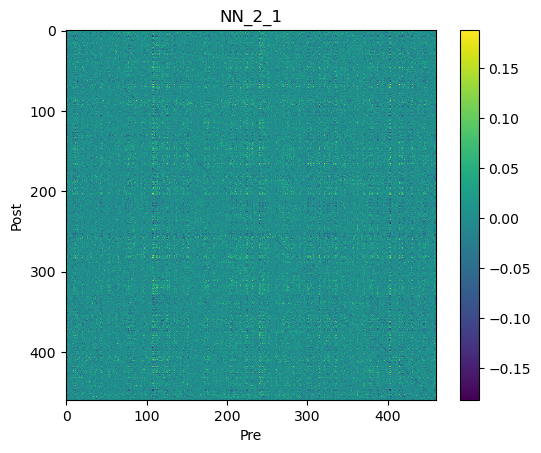

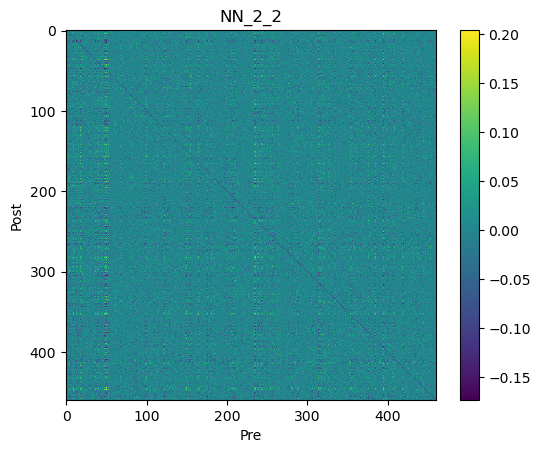

In [56]:
k = 2
train_dataloader_list, val_dataloader_list, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, sessions_2_original_cell_type, neuron_id_2_cell_type_id = data.generate_mouse_all_sessions_data_for_GLM(
    k=k, 
    batch_size=batch_size, 
    normalization=normalization
)

checkpoint_path = "../../output/4_29_GLM_M/k=2.ckpt"   #############################
trained_model_2 = baselines.GLM_M.load_from_checkpoint(checkpoint_path=checkpoint_path)
trained_model_2.eval()

train_data_x_2 = []
train_data_y_2 = []
for idx, batch in enumerate(train_dataloader_list[0]):
    x = batch[0]
    target = x[:, :, -1].clone()
    train_data_x_2.append(x[:, :, :-1])
    train_data_y_2.append(target)

train_data_x_2 = torch.cat(train_data_x_2, dim=0)
train_data_y_2 = torch.cat(train_data_y_2, dim=0)

print(train_data_x_2.shape)
print(train_data_y_2.shape)

NN_2_1 = trained_model_2.W_list[0].weight.data.cpu().detach()
NN_2_2 = trained_model_2.W_list[1].weight.data.cpu().detach()
NN_2_1_new = tools.group_connectivity_matrix_by_cell_type(NN_2_1, neuron_id_2_cell_type_id)

plt.imshow(NN_2_1_new, interpolation="nearest")
plt.colorbar()
plt.xlabel("Pre")
plt.ylabel("Post")
plt.title("NN_2_1")
plt.show()

plt.imshow(NN_2_2, interpolation="nearest")
plt.colorbar()
plt.xlabel("Pre")
plt.ylabel("Post")
plt.title("NN_2_2")
plt.show()
